## Creación de la base de datos desde python

Lo primero es ir a DBeaver y crearnos una base de datos llamada 'supermercados'

Después nos conectamos a la bbdd:

In [13]:
import pandas as pd
import numpy as np
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Agregar el directorio 'src' al path
sys.path.append(os.path.abspath('../src'))

# Importar la función suma del módulo auxiliares
import funciones_auxiliares as fa

In [2]:
conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()

Creamos las tablas:

In [3]:
fa.creacion_tablas(conexion, cursor)

Inserción de datos en las tablas:

In [4]:
fa.insercion_supermercados(conexion, cursor)
fa.insercion_productos(conexion, cursor)
fa.insercion_marcas(conexion, cursor)
fa.insercion_comparativa(conexion, cursor)

# Consultas a la bbdd

In [3]:
conexion = fa.conexion_bbdd("supermercados")

Precio medio de cada producto por supermercado.

In [33]:
cursor = conexion.cursor()
cursor.execute(""" SELECT nombre
FROM supermercados s;""")
lista_supermercados = pd.DataFrame(cursor.fetchall())[0].to_list()
lista_supermercados

['alcampo', 'carrefour', 'dia', 'eroski', 'hipercor', 'mercadona']

In [36]:
cursor = conexion.cursor()
cursor.execute(""" SELECT nombre
FROM tipo_producto tp;""")
res = cursor.fetchall()
lista_productos_1 = pd.DataFrame(res)[0].to_list()
lista_productos_2 = pd.DataFrame(res)[0].str.replace(" ", "_").to_list()

['aceite_de_girasol', 'aceite_de_oliva', 'leche']

In [62]:
conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
for super in lista_supermercados:
    for i in range(len(lista_productos_1)):
        cursor = conexion.cursor()
        cursor.execute(f""" CREATE VIEW media_{super}_{lista_productos_2[i]} AS (
                            SELECT nombre_producto, round(avg(precio),2) AS precio_medio
                            FROM(SELECT c.nombre AS nombre_producto, precio
                                FROM comparativa c
                                INNER JOIN supermercados s ON c.id_supermercado = s.id_supermercado 
                                INNER JOIN tipo_producto tp ON c.id_producto = tp.id_producto
                                WHERE s.nombre = '{super}' AND tp.nombre='{lista_productos_1[i]}') AS taux
                            GROUP BY nombre_producto
                            ORDER BY precio_medio); """)
        conexion.commit()  


In [4]:
conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(""" SELECT *
                    FROM media_dia_leche;""")
pd.DataFrame(cursor.fetchall()).head(2)

,0,1
0,leche semidesnatada central lechera asturiana ...,0.70
1,leche desnatada dia lactea brik 1 l,0.79


### Obtengamos los 10 productos con mayor variación de precio:

In [7]:
consulta= """SELECT nombre, min(precio) AS precio_min, max(precio) AS precio_max, max(precio)-min(precio) AS diferencia
            FROM comparativa c 
            GROUP BY nombre
            ORDER BY diferencia DESC
            LIMIT 10;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df_1 = pd.DataFrame(data, columns=column_names)

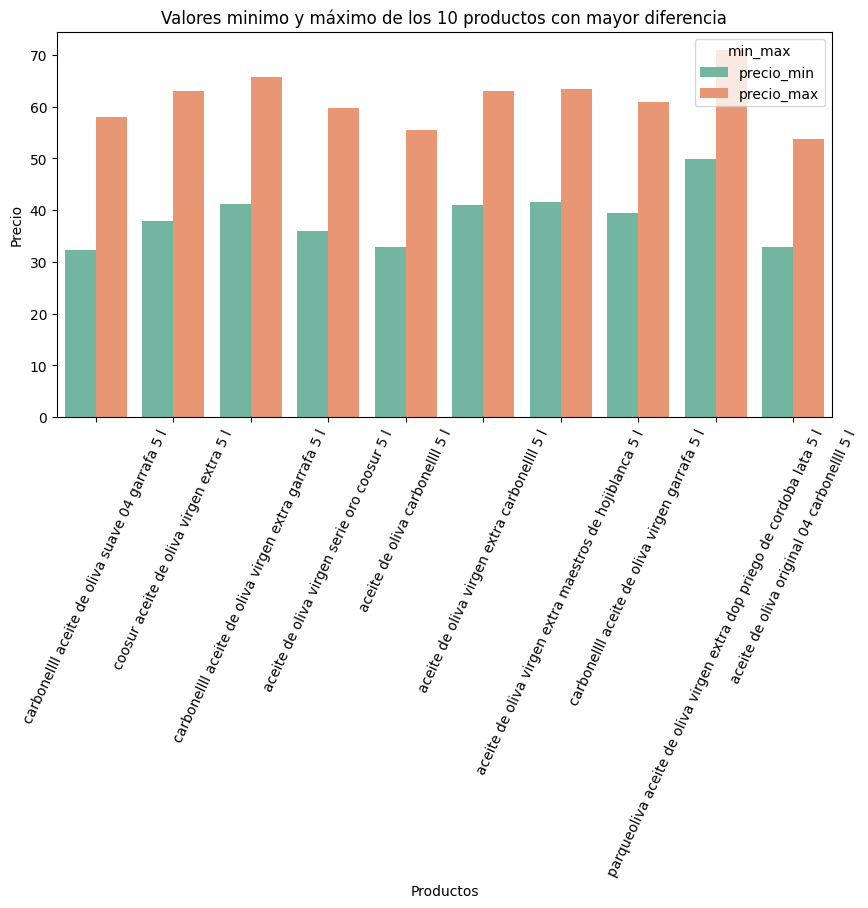

In [23]:
df_melt = df_1.melt(id_vars="nombre", value_vars=["precio_min", "precio_max"], var_name="min_max", value_name="monto")

plt.figure(figsize=(10, 5))
sns.barplot(x="nombre", y="monto", hue="min_max", palette="Set2", data=df_melt)

plt.title("Valores mínimo y máximo de los 10 productos con mayor diferencia")

plt.xticks(rotation=65)
plt.xlabel("Productos")
plt.ylabel("Precio")
plt.show()

El producto que mayor diferencia de precio ha tenido son sin duda alguna son las garrafas de aceite de oliva de 5l. Lo que nos lleva a preguntarnos, ¿cuál es la mayor oscilación para las botellas de 1L?

### Comparativa de precios para los distintos productos con capacidad de 1L

Aceite de oliva:

In [36]:
consulta = """SELECT nombre, min(precio) AS precio_min, max(precio) AS precio_max, max(precio)-min(precio) AS diferencia, min(marca) as marca
            FROM (SELECT c.nombre, c.precio, m.nombre AS marca
                    FROM comparativa c
                    INNER JOIN tipo_producto tp ON tp.id_producto =c.id_producto
                    INNER JOIN marcas m ON m.id_marca = c.id_marca
                    WHERE cantidad = '1 l' AND tp.nombre ='aceite de oliva') AS taux
            GROUP BY nombre
            ORDER BY diferencia DESC
            LIMIT 10;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df = pd.DataFrame(data, columns=column_names)

In [31]:
np.mean(df["diferencia"])

np.float64(5.869)

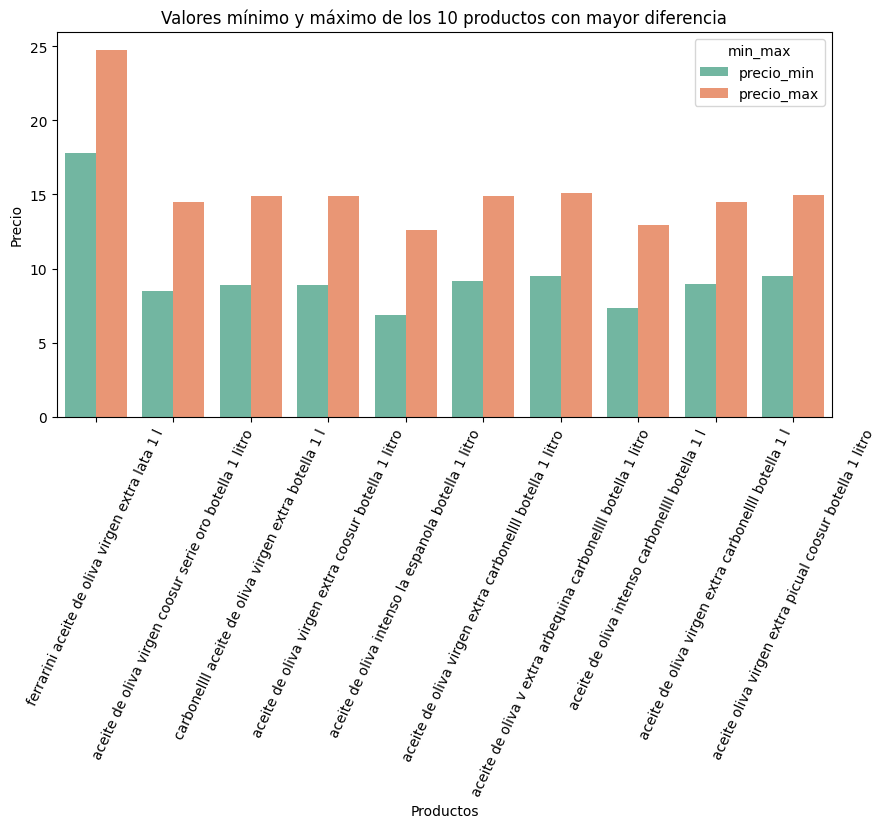

In [30]:
df_melt = df.melt(id_vars="nombre", value_vars=["precio_min", "precio_max"], var_name="min_max", value_name="monto")

plt.figure(figsize=(10, 5))
sns.barplot(x="nombre", y="monto", hue="min_max", palette="Set2", data=df_melt)

plt.title("Valores mínimo y máximo de los 10 aceites de oliva con mayor diferencia")

plt.xticks(rotation=65)
plt.xlabel("Productos")
plt.ylabel("Precio")
plt.show()

La mayor diferencia esta en 6.9 euros siendo la marca ferrarini la que encabeza la gráfica. La marca que más se repite es carbonell seguida de coosur entre las principales con las mayores subidas de precio. La media de diferencia de precios de los 10 primeros es de 5.87 euros.

Aceite de girasol:

In [43]:
consulta = """SELECT nombre, min(precio) AS precio_min, max(precio) AS precio_max, max(precio)-min(precio) AS diferencia, min(marca) as marca
            FROM (SELECT c.nombre, c.precio, m.nombre AS marca
                    FROM comparativa c
                    INNER JOIN tipo_producto tp ON tp.id_producto =c.id_producto
                    INNER JOIN marcas m ON m.id_marca = c.id_marca
                    WHERE cantidad = '1 l' AND tp.nombre ='aceite de girasol') AS taux
            GROUP BY nombre
            ORDER BY diferencia DESC
            LIMIT 10;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df_girasol = pd.DataFrame(data, columns=column_names)

In [44]:
df_girasol

,nombre,precio_min,precio_max,diferencia,marca
0,aceite de girasol especial para freir coosol b...,1.7900,3.1200,1.3300,coosol
1,la masia aceite de girasol botella 1 l,1.2900,2.3400,1.0500,la masia
2,koipesol aceite de girasol botella de 1 l,1.2700,2.2900,1.0200,koipe
3,aceite girasol tradicional coosol botella 1 litro,1.3900,2.3900,1.0000,coosol
4,aceite de girasol especial para freir koipe bo...,1.8000,2.7500,0.9500,koipe
5,aceite de girasol koipe botella 1 l,1.7100,2.6500,0.9400,koipe
6,koipe fritos aceite de girasol especial para f...,1.7500,2.6400,0.8900,koipe
7,aceite de girasol koipe sol 1 l,1.7100,2.5900,0.8800,koipe
8,borgesol aceite refinado de girasol botella 1 l,3.2500,3.9900,0.7400,borgesol
9,borges borgefrit aceite refinado de girasol pa...,2.4500,3.0600,0.6100,borges


In [50]:
print(np.mean(df_girasol["diferencia"]))
df_girasol["marca"].value_counts()

0.9410000000000001


marca
koipe       5
coosol      2
la masia    1
borgesol    1
borges      1
Name: count, dtype: int64

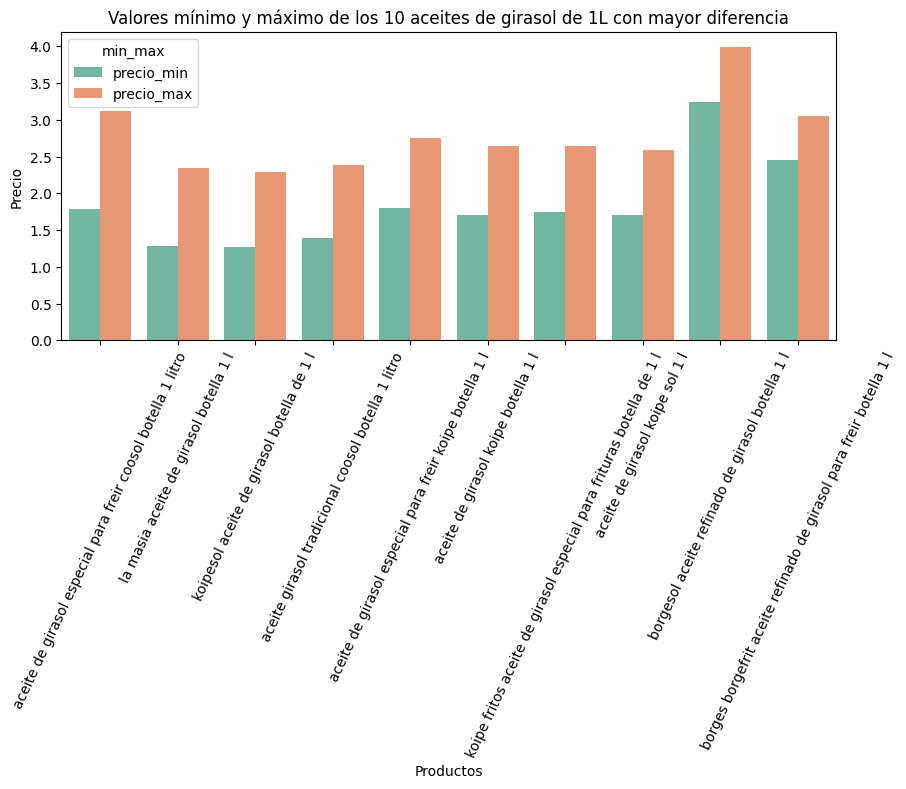

In [47]:
df_melt = df_girasol.melt(id_vars="nombre", value_vars=["precio_min", "precio_max"], var_name="min_max", value_name="monto")

plt.figure(figsize=(10, 4))
sns.barplot(x="nombre", y="monto", hue="min_max", palette="Set2", data=df_melt)

plt.title("Valores mínimo y máximo de los 10 aceites de girasol de 1L con mayor diferencia")

plt.xticks(rotation=65)
plt.xlabel("Productos")
plt.ylabel("Precio")
plt.show()

En el caso de los aceites de girasol de 1L la mayor diferenecia de precios es de 1.33 y en la cola del top 10 la diferencia es de 0.6. La marca que encabeza las subidas de precio es coosol, sin embargo en el top 10 de incrementos la marca más repetida es koipe. La media de incrementos es de 0.94.

Leche:


In [53]:
consulta = """SELECT nombre, min(precio) AS precio_min, max(precio) AS precio_max, max(precio)-min(precio) AS diferencia, min(marca) as marca
            FROM (SELECT c.nombre, c.precio, m.nombre AS marca
                    FROM comparativa c
                    INNER JOIN tipo_producto tp ON tp.id_producto =c.id_producto
                    INNER JOIN marcas m ON m.id_marca = c.id_marca
                    WHERE cantidad = '1 l' AND tp.nombre ='leche') AS taux
            GROUP BY nombre
            ORDER BY diferencia DESC
            LIMIT 10;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df_leche = pd.DataFrame(data, columns=column_names)

In [54]:
df_leche

,nombre,precio_min,precio_max,diferencia,marca
0,kaiku leche entera de vaca sin lactosa 1 l,0.5000,1.2900,0.7900,kaiku
1,puleva omega 3 preparado lacteo desnatado sin ...,0.9000,1.6800,0.7800,puleva
2,priegola leche entera fresca 1 l,1.6500,2.2000,0.5500,priegola
3,president leche desnatada de vaca de origen 10...,0.5000,1.0500,0.5500,president
4,leche semidesnatada vitacalcio puleva sin lact...,1.2500,1.7600,0.5100,puleva
5,puleva proteina extra pro leche de vaca desnat...,1.0000,1.5000,0.5000,puleva
6,preparado lacteo ligero flora floricb brik 1 l...,1.5900,2.0500,0.4600,flora
7,preparado lacteo original flora folicb brik 1 ...,1.5900,2.0500,0.4600,flora
8,leche semidesnatada president sin lactosa brik...,1.0000,1.4400,0.4400,president
9,priegola leche semidesnatada fresca sin lactos...,1.8200,2.2500,0.4300,priegola


In [55]:
print(np.mean(df_leche["diferencia"]))
df_leche["marca"].value_counts()

0.5469999999999999


marca
puleva       3
president    2
priegola     2
flora        2
kaiku        1
Name: count, dtype: int64

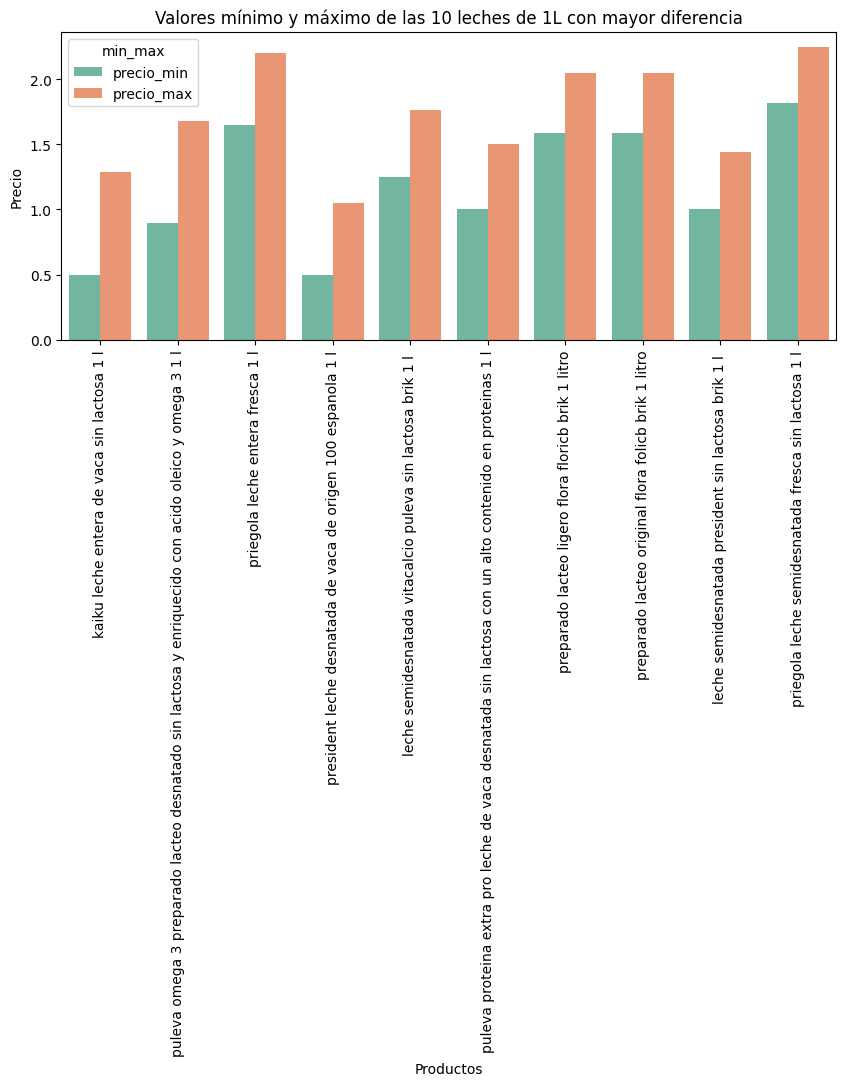

In [57]:
df_melt = df_leche.melt(id_vars="nombre", value_vars=["precio_min", "precio_max"], var_name="min_max", value_name="monto")

plt.figure(figsize=(10, 4))
sns.barplot(x="nombre", y="monto", hue="min_max", palette="Set2", data=df_melt)

plt.title("Valores mínimo y máximo de las 10 leches de 1L con mayor diferencia")

plt.xticks(rotation=90)
plt.xlabel("Productos")
plt.ylabel("Precio")
plt.show()

La mayor diferencia es de 0.79 euros lo cual representa un incremento del 158%, la marca de este producto es kaiku, sin embargo la marca que mas veces aparece en el top 10 es puleva. La media de subida de los precios es de 0.55.

### Veamos que marcas han sufrido mas incrementos o decrementos

Veamos cuantos aumentos ha sufrido cada marca y cuales son las que mayor media de aumento presentan.

Aceite de girasol:

In [70]:
consulta = """SELECT nombre AS marca, num_incrementos, round(media_incremento,2) as porcentaje_media
            FROM (SELECT id_marca, incremento, count(incremento) AS num_incrementos, avg(porcentaje) AS media_incremento, id_producto
                FROM comparativa c 
                GROUP BY id_marca, incremento, id_producto
                HAVING incremento = 'aumento' AND id_producto=1) AS taux
            INNER JOIN marcas m ON m.id_marca = taux.id_marca
            ORDER BY media_incremento DESC
            limit 10;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df_aceite_aumento = pd.DataFrame(data, columns=column_names)

In [71]:
df_aceite_aumento

,marca,num_incrementos,porcentaje_media
0,la masia,5,28.27
1,koipe,60,21.91
2,borges,3,14.82
3,coosol,25,12.82
4,cexasol,2,9.87
5,urzante,2,8.70
6,borgesol,4,8.62
7,ozolife,2,6.69
8,elosol,2,4.12
9,carrefour,6,3.02


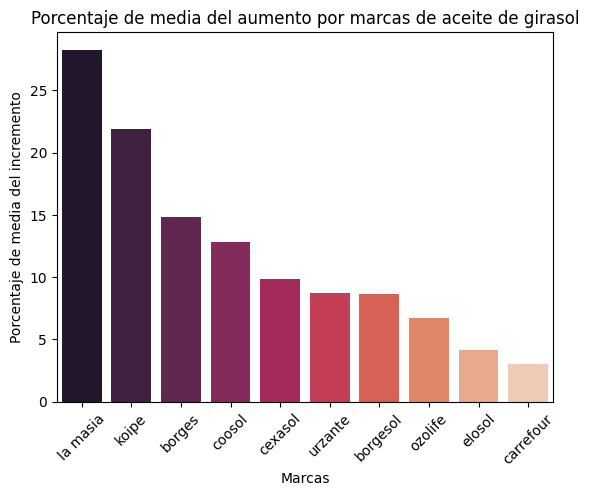

In [74]:
sns.barplot(x="marca", 
            y="porcentaje_media",
            data = df_aceite_aumento,
            palette="rocket",
            )

plt.xticks(rotation=45)

plt.title("Porcentaje de media del aumento por marcas de aceite de girasol")
plt.xlabel("Marcas")
plt.ylabel("Porcentaje de media del incremento")
plt.show()

Entre las marcas de aceite de girasol, las que mayor porcentaje de aumento presentan de media son 'La Masía' seguida de 'Koipe', ambas sufriendo incrementos cuya media es de mas de un 20%.

Aceite de oliva:

In [78]:
consulta = """SELECT nombre AS marca, num_incrementos, round(media_incremento,2) as porcentaje_media
            FROM (SELECT id_marca, incremento, count(incremento) AS num_incrementos, avg(porcentaje) AS media_incremento, id_producto
                FROM comparativa c 
                GROUP BY id_marca, incremento, id_producto
                HAVING incremento = 'aumento' AND id_producto=2) AS taux
            INNER JOIN marcas m ON m.id_marca = taux.id_marca
            ORDER BY media_incremento DESC
            limit 10;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df_aceite_oliva_aumento = pd.DataFrame(data, columns=column_names)

In [79]:
df_aceite_oliva_aumento

,marca,num_incrementos,porcentaje_media
0,molino de olivas de bolea,2,29.21
1,koipe,16,22.21
2,ferrarini,2,19.07
3,guillen,14,18.41
4,la espanola,78,16.89
5,coosur,113,16.74
6,carbonell,224,16.69
7,arronizarbe,3,16.31
8,abril,36,16.01
9,parqueoliva,10,14.72


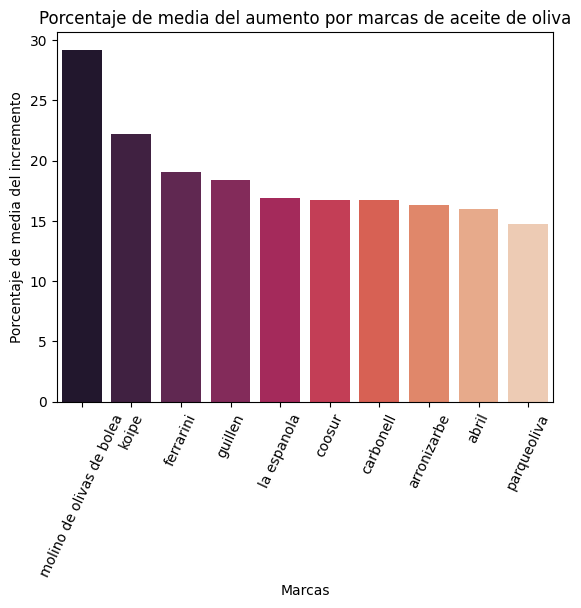

In [81]:
sns.barplot(x="marca", 
            y="porcentaje_media",
            data = df_aceite_oliva_aumento,
            palette="rocket",
            )

plt.xticks(rotation=65)

plt.title("Porcentaje de media del aumento por marcas de aceite de oliva")
plt.xlabel("Marcas")
plt.ylabel("Porcentaje de media del incremento")
plt.show()

Las marcas de aceite de girasol que han experimentado un mayor incremento de media en tanto por ciente son: Molinos de olivas de bolea con casi un 30% de media de sus incremetos, seguida de koipe con un 22% y Ferrarini con un 19%. Como podemos observar de nuevo koipe está en el segundo puesto.

Leche:

In [89]:
consulta = """SELECT nombre AS marca, num_incrementos, round(media_incremento,2) as porcentaje_media
            FROM (SELECT id_marca, incremento, count(incremento) AS num_incrementos, avg(porcentaje) AS media_incremento, id_producto
                FROM comparativa c 
                GROUP BY id_marca, incremento, id_producto
                HAVING incremento = 'aumento' AND id_producto=3) AS taux
            INNER JOIN marcas m ON m.id_marca = taux.id_marca
            ORDER BY media_incremento DESC
            limit 10;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df_leche_aumento = pd.DataFrame(data, columns=column_names)

In [90]:
df_leche_aumento.head(10)

,marca,num_incrementos,porcentaje_media
0,lr,16,22.62
1,flora,5,21.16
2,president,61,14.00
3,rio,17,13.14
4,priegola,5,11.86
5,puleva,215,11.63
6,kaiku,62,11.02
7,pascual,148,10.60
8,el castillo,6,7.80
9,asturiana,263,6.51


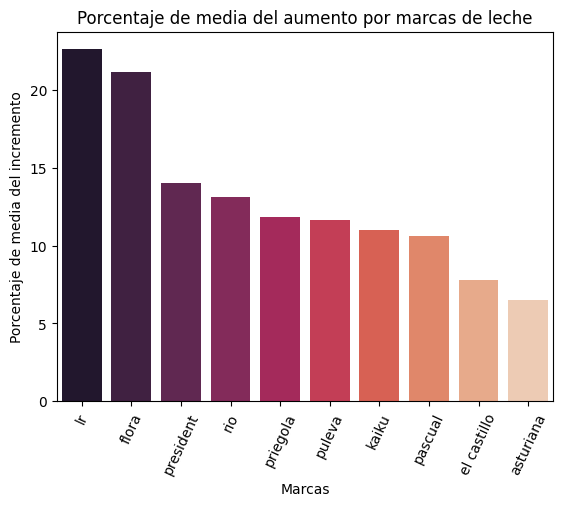

In [91]:
sns.barplot(x="marca", 
            y="porcentaje_media",
            data = df_leche_aumento,
            palette="rocket",
            )

plt.xticks(rotation=65)

plt.title("Porcentaje de media del aumento por marcas de leche")
plt.xlabel("Marcas")
plt.ylabel("Porcentaje de media del incremento")
plt.show()

Las dos principales marcas de leche que han sufrido de media un mayor incremento en sus precios son Lr con un 22.6% y flora con un 21.16%.

Ahora tambien nos gustaría saber que días suele haber aumentos y decrementos para comprobar si hay algún día de la semana con mayor tendencia.

In [95]:
consulta = """SELECT dia_semana,
                SUM(CASE WHEN incremento = 'aumento' THEN 1 ELSE 0 END) AS total_aumentos,
                SUM(CASE WHEN incremento = 'decremento' THEN 1 ELSE 0 END) AS total_decrementos
            FROM comparativa c 
            GROUP BY dia_semana;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df_dia_semana = pd.DataFrame(data, columns=column_names)

In [96]:
df_dia_semana


,dia_semana,total_aumentos,total_decrementos
0,domingo,33,13
1,jueves,625,524
2,lunes,221,294
3,martes,553,375
4,miércoles,660,346
5,sábado,35,86
6,viernes,294,252


In [97]:
orden_semana = ["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]
# Convertimos la columna 'dia_semana' en un tipo categórico con el orden deseado
df_dia_semana['dia_semana'] = pd.Categorical(df_dia_semana['dia_semana'], categories=orden_semana, ordered=True)
# Ordenamos el DataFrame según la columna 'dia_semana'
df_dia_semana = df_dia_semana.sort_values(by='dia_semana').reset_index(drop=True)
df_dia_semana

,dia_semana,total_aumentos,total_decrementos
0,lunes,221,294
1,martes,553,375
2,miércoles,660,346
3,jueves,625,524
4,viernes,294,252
5,sábado,35,86
6,domingo,33,13


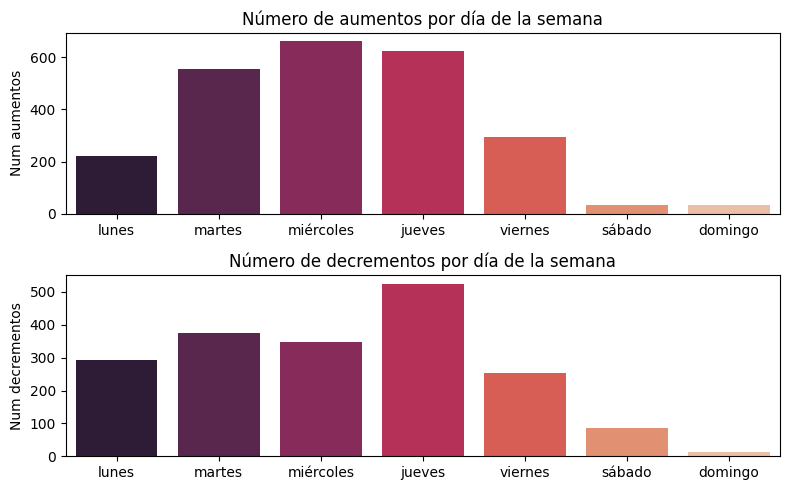

In [100]:
fig, axes = plt.subplots(2,1, figsize=(8,5))

sns.barplot(x="dia_semana", y="total_aumentos", data = df_dia_semana, palette="rocket", ax=axes[0])
sns.barplot(x="dia_semana", y="total_decrementos", data = df_dia_semana, palette="rocket", ax=axes[1])



axes[0].set_title("Número de aumentos por día de la semana")
axes[1].set_title("Número de decrementos por día de la semana")

axes[0].set_xlabel("")
axes[0].set_ylabel("Num aumentos")
axes[1].set_xlabel("")
axes[1].set_ylabel("Num decrementos")

plt.tight_layout()  # Ajustar el layout para que no se solapen
plt.show()

Como podemos observar el día en el cual se ha experimentado mayor subida de precios es el miércoles, seguido de cerca por el jueves y martes. En cuanto los días con más bajadas de precios son los jueves, seguido de martes y miércoles. Por lo tanto, en los mismo días son en los que más subidas y bajadas se registran. Si quisiera asegurarme de que no va a haber muchas subidas pero quizás alguna bajada iría al super un sábado.

### Productos más baratos de cada tipo por supermercado.

Puede ser un ejercicio interesante ver cual es el aceite de oliva, de girasol y la leche más barata en cada super y cuya cantidad sea 1L.

In [103]:
consulta = """SELECT DISTINCT ON (s.nombre, tp.nombre, c2.nombre, taux.precio_minimo)
                s.nombre,
                tp.nombre,
                c2.nombre,
                round(taux.precio_minimo, 2)
            FROM (
                SELECT id_supermercado, id_producto, min(precio) AS precio_minimo
                FROM comparativa 
                WHERE cantidad = '1 l'
                GROUP BY id_supermercado, id_producto
            ) AS taux
            LEFT JOIN comparativa c2 ON c2.id_supermercado = taux.id_supermercado 
                AND c2.id_producto = taux.id_producto 
                AND c2.precio = taux.precio_minimo
                AND c2.cantidad = '1 l'
            LEFT JOIN supermercados s ON s.id_supermercado = c2.id_supermercado
            LEFT JOIN tipo_producto tp ON tp.id_producto = c2.id_producto
            ORDER BY s.nombre, tp.nombre;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df_productos_baratos = pd.DataFrame(data, columns=column_names)


In [104]:
df_productos_baratos

,nombre,nombre,nombre,round
0,alcampo,aceite de girasol,koipesol aceite de girasol botella de 1 l,1.27
1,alcampo,aceite de oliva,producto alcampo aceite de orujo de oliva bote...,4.65
2,alcampo,leche,kaiku leche entera de vaca sin lactosa 1 l,0.50
3,alcampo,leche,president leche desnatada de vaca de origen 10...,0.50
4,carrefour,aceite de girasol,aceite de girasol carrefour classic 1 l,1.45
5,carrefour,aceite de oliva,aceite de orujo de oliva 1 l,4.99
6,carrefour,leche,leche desnatada brik 1 l,0.73
7,carrefour,leche,leche entera brik 1 l,0.73
8,carrefour,leche,leche semidesnatada brik 1 l,0.73
9,dia,aceite de girasol,aceite refinado de girasol diasol botella 1 l,1.49


En cuanto a los aceites de girasol, los mas baratos suelen ser los de la propia marca de cada supermercado, a excepción del alcampo donde es koipesol, en el eroski coosol y en el hipercor abrisol. Respecto al aceite de oliva suele ser más barato el de orujo, excepto en el hipercor y mercadona donde las marcas más baratas son abril y el hacendado. En cuanto la leche, en alcampo sorprende con dos leches de marca como son president y kaiku a 50 centimos el litro, en el resto predominan las marcas propias de cada supermercado.

### Precios que más han aumentado en el último mes.

In [105]:
consulta= """SELECT nombre, 
            MAX(CASE WHEN fecha = '2024-10-25' THEN precio END) - 
            MAX(CASE WHEN fecha = '2024-10-01' THEN precio END) AS diferencia_precio
        FROM comparativa c 
        WHERE fecha ='2024-10-01' OR fecha='2024-10-25'
        GROUP BY "nombre"
        HAVING COUNT(DISTINCT fecha) = 2
        ORDER BY diferencia_precio desc;"""

conexion = fa.conexion_bbdd("supermercados")
cursor = conexion.cursor()
cursor.execute(consulta)
data = cursor.fetchall()

# Extrae los nombres de las columnas de cursor.description
column_names = [desc[0] for desc in cursor.description]

# Crea el DataFrame con los nombres de columnas
df_aumento_octube = pd.DataFrame(data, columns=column_names)

In [110]:
pd.set_option("display.max_rows", None)
df_aumento_octube.head(5)

,nombre,diferencia_precio
0,la espanola aceite de oliva virgen extra garra...,11.5200
1,coosur aceite de oliva virgen serie oro garraf...,7.2500
2,jaencoop aceite de oliva virgen extra picual g...,4.1600
3,oleoestepa aceite de oliva virgen extra dop es...,3.9100
4,aceite de oliva virgen coosur serie oro garraf...,3.5000


In [108]:
df_aumento_octube.tail(5)

,nombre,diferencia_precio
955,aceite de oliva intenso la espanola botella 1 ...,-5.7600
956,aceite de oliva 04 carbonellll garrafa 3 litros,-7.1500
957,abril aceite de oliva intenso 1 garrafa 5 l,-8.8300
958,carbonellll aceite de oliva virgen extra garra...,-9.5800
959,coosur aceite de oliva virgen cocina mediterra...,-16.4200


Los prodcutos que mayor subida de precio han experimentado del 1 de octubre a hoy son los aceites de oliva virgen extra en garrafas de 5 o 3 litros. Por otro lado los productos que más diferencia tienen de precio son de nuevo los aceites de oliva en garrfas de 5 o 3l siendo el producto 'coosur aceite de oliva virgen cocina mediterranea garrafa de 5 l' el cual cuesta 16,42 euros menos el día 25 respecto del 1.